In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from math import radians
from PIL import Image  # PIL modülü eklendi

class ImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])

        # PIL ile görseli yükle
        image = Image.open(img_path).convert('RGB')  # Görseli RGB'ye çevir

        if self.transform:
            image = self.transform(image)

        lat, lon = row['latitude'], row['longitude']
        return image, lat, lon

# 2. Veri Yükleme ve Ön İşleme
df = pd.read_csv('/content/drive/MyDrive/datathon/itüai/train.csv', sep=";")
image_dir = "/content/drive/MyDrive/datathon/itüai/train"

# Dönüşümler
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset ve DataLoader
dataset = ImageDataset(df, image_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False,num_workers=4)

# 3. ResNet50 Özellik Çıkarma
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Son katmanı kaldır
model = model.to(device)
model.eval()

# Özellik çıkarma
features = []
lat_lon = []

with torch.no_grad():
    for images, lat, lon in data_loader:
        images = images.to(device)
        output = model(images)
        features.append(output.cpu().numpy())
        lat_lon.extend(zip(lat.numpy(), lon.numpy()))

features = np.vstack(features)
lat_lon = np.array(lat_lon)

# 4. L2 Mesafesi Hesaplama
l2_distance_matrix = pairwise_distances(features, metric='euclidean')

# 5. Haversine Mesafesi Hesaplama
def haversine(lat1, lon1, lat2, lon2):
    r = 6371  # Dünya'nın yarıçapı (km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(radians(lat1)) * np.cos(radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return r * c

# Lat/Lon verilerini radyanlara çevir ve mesafeleri hesapla
lat_lon_radians = np.radians(lat_lon)
haversine_distance_matrix = pairwise_distances(lat_lon_radians, metric='haversine') * 6371  # km cinsinden



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


In [ ]:
# Min-Max Normalizasyon
def normalize_matrix(matrix):
    return (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

# L2 ve Haversine mesafelerini normalize et
l2_distance_matrix_normalized = normalize_matrix(l2_distance_matrix)
haversine_distance_matrix_normalized = normalize_matrix(haversine_distance_matrix)

# Birleştirilmiş mesafe matrisi
combined_distance_matrix = (
    0.4 * l2_distance_matrix_normalized +
    0.6 * (1-haversine_distance_matrix_normalized)
)



In [ ]:
combined_distance_matrix.shape

(4375, 4375)

In [ ]:
df['cluster'].value_counts()

,count
cluster,
11,568
4,530
12,520
8,452
2,377
5,328
6,303
3,303
1,284


In [ ]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=35, affinity='precomputed')
clusters = spectral_clustering.fit_predict(combined_distance_matrix)
print("Spektral Kümeleme Sonuçları:", clusters)

Spektral Kümeleme Sonuçları: [15 24  7 ... 20 17  2]


In [ ]:
df['cluster'] = clusters

In [ ]:
df.head()

,filename,latitude,longitude,cluster
0,/content/drive/MyDrive/datathon/itüai/train/i...,41.106903,29.020718,12
1,/content/drive/MyDrive/datathon/itüai/train/i...,41.101802,29.022086,4
2,/content/drive/MyDrive/datathon/itüai/train/i...,41.107780,29.026120,10
3,/content/drive/MyDrive/datathon/itüai/train/i...,41.107732,29.023701,2
4,/content/drive/MyDrive/datathon/itüai/train/i...,41.107525,29.031178,5


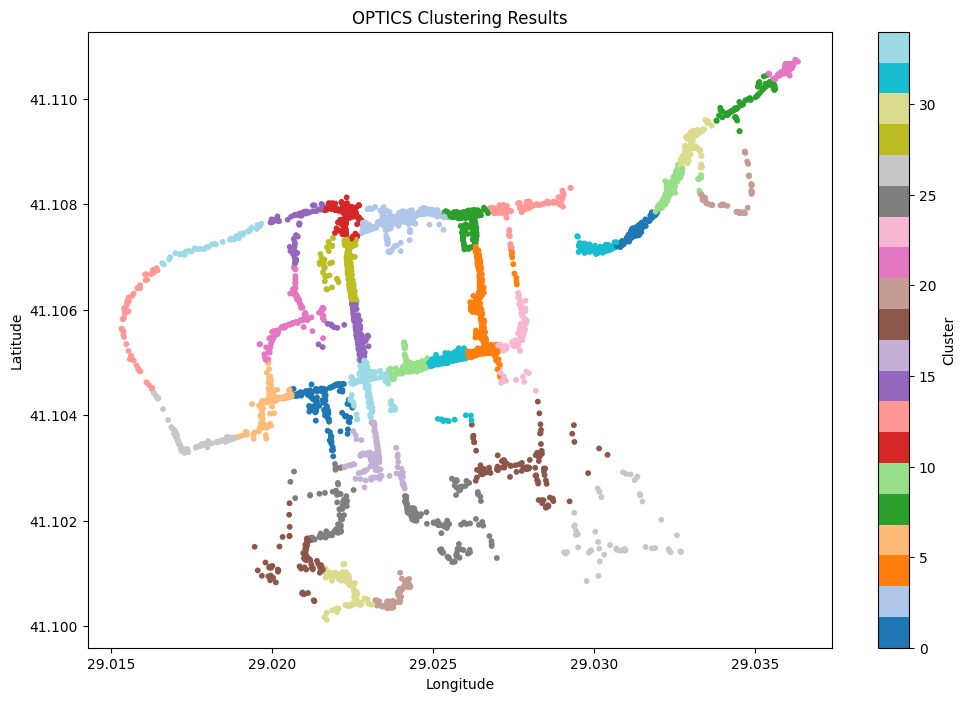

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='tab20', s=10)
plt.colorbar(label='Cluster')
plt.title("OPTICS Clustering Results")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



In [ ]:
# Görsellerin bulunduğu klasör
image_dir = "/content/drive/MyDrive/datathon/itüai/train"

# Görsel yollarını oluşturma
df['filename'] = df['filename'].apply(lambda x: os.path.join(image_dir, x))


In [ ]:
############################################
# train_pipeline.py
############################################
import os
import math
import torch
import random
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader

###########################################
# Gaussian Noise Class for Augmentation
###########################################
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=0.5):
        """
        mean: Gürültünün ortalama değeri.
        std: Gürültünün standart sapması.
        p: Gürültünün uygulanma olasılığı (0 ile 1 arasında).
        """
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, tensor):
        if random.random() < self.p:  # Gürültüyü p olasılıkla uygula
            noise = torch.randn(tensor.size()) * self.std + self.mean
            return tensor + noise
        return tensor  # Gürültü uygulanmazsa orijinal tensörü döndür

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std}, p={self.p})"


###########################################
# 1) Yardımcı Fonksiyonlar
###########################################
def euclidean_distance(x, y):
    return torch.sqrt(((x - y) ** 2).sum())

def haversine_distance(lat1, lon1, lat2, lon2, r=6371.0):
    """
    Coğrafi uzaklık için Haversine metodu.
    """
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (math.sin(dlat / 2)**2
         + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2)
    c = 2 * math.asin(math.sqrt(a))
    return r * c

###########################################
# 2) Dataset Sınıfı
###########################################
class GeoClusterDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        df: [image_path, latitude, longitude, cluster]
        transform: torchvision transforms
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

        self.unique_clusters = sorted(self.df['cluster'].unique())
        self.cluster2idx = {cl: i for i, cl in enumerate(self.unique_clusters)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['filename']
        cl = row['cluster']

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        cl_idx = self.cluster2idx[cl]
        return image, cl_idx

###########################################
# 3) Model Oluşturma
###########################################
def create_model(num_clusters):
    """
    ResNet18'i yükleyip, son katmanını (fc) cluster sayısı kadar çıktıya ayarla.
    """
    model = torchvision.models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_clusters)
    return model

###########################################
# 4) Eğitim ve Değerlendirme Fonksiyonları
###########################################
def train_one_epoch(model, dataloader, optimizer, device='cuda'):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, device='cuda'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc

###########################################
# 5) Ana Eğitim Pipeline
###########################################
def train_cluster_classifier(df_train,
                            df_val=None,
                            batch_size=32,
                            epochs=5,
                            lr=1e-4,
                            device='cuda'):
    """
    df_train, df_val: [image_path, latitude, longitude, cluster]
    """
    train_transform = T.Compose([
        T.Resize((512, 512)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        AddGaussianNoise(mean=0.0, std=0.05, p=0.3)  # %30 olasılıkla gürültü ekle
    ])


    val_transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    train_dataset = GeoClusterDataset(df_train, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

    if df_val is not None and len(df_val) > 0:
        val_dataset = GeoClusterDataset(df_val, transform=val_transform)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
    else:
        val_loader = None

    num_clusters = len(train_dataset.unique_clusters)
    model = create_model(num_clusters)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # cluster mapping (dataset'ten)
    idx2cluster = {v: k for k, v in train_dataset.cluster2idx.items()}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device=device)

        if val_loader is not None:
            val_loss, val_acc = evaluate(model, val_loader, device=device)
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Son durumda eğitilmiş model ve cluster indeksi -> cluster etiketi map'i döndür
    return model, idx2cluster

###########################################
# 6) Cluster Bazlı Embedding Çıkarma
###########################################
@torch.no_grad()
def extract_cluster_embeddings(trained_model, df, device='cuda'):
    """
    trained_model (ResNet18 + son fc)
    df: [image_path, latitude, longitude, cluster]

    cluster2embeds: { cluster_label: np.array(shape=(N, 512)), ... }
    cluster2coords: { cluster_label: np.array(shape=(N, 2)), ... }

    Not: 'N' her bir cluster'ın veri sayısı kadardır.
    """
    # 1) Feature extractor: model'in son fc katmanını sıyırıyoruz
    feature_extractor = nn.Sequential(*list(trained_model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # 2) Transform
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    # 3) cluster2embeds, cluster2coords yapılarını oluştur
    cluster2embeds = {}
    cluster2coords = {}
    unique_clusters = sorted(df['cluster'].unique())
    for c in unique_clusters:
        cluster2embeds[c] = []
        cluster2coords[c] = []

    # 4) Tek tek her satır için embedding al
    for i in range(len(df)):
        row = df.iloc[i]
        img_path = row['filename']
        cl = row['cluster']
        lat, lon = row['latitude'], row['longitude']

        img = Image.open(img_path).convert("RGB")
        img_t = transform(img).unsqueeze(0).to(device)  # (1, C, H, W)

        emb = feature_extractor(img_t)  # (1, 512, 1, 1)
        emb = emb.view(emb.size(0), -1) # (1, 512)
        emb_np = emb[0].cpu().numpy()   # (512,)

        cluster2embeds[cl].append(emb_np)
        cluster2coords[cl].append([lat, lon])

    # 5) list'leri numpy array'e çevir
    for c in cluster2embeds:
        cluster2embeds[c] = np.array(cluster2embeds[c])  # shape: (N, 512)
        cluster2coords[c] = np.array(cluster2coords[c])  # shape: (N, 2)

    return cluster2embeds, cluster2coords

###########################################
# 7) Konumu "Tam" Retrieval ile İyileştirme
###########################################
def refine_location_full(test_image_path,
                         trained_model,
                         cluster2embeds,
                         cluster2coords,
                         idx2cluster,
                         device='cuda'):
    """
    1) test_image_path'i aç, modelin "sınıflandırma" çıktısını al -> cluster tahmini.
    2) embedding çıkar (fc hariç).
    3) Tahmin edilen cluster içindeki tüm embedding'lerle mesafe karşılaştır.
    4) En yakın embedding'in (lat, lon) koordinatını döndür.

    Geri dönüş:
      predicted_cluster_label: str (cluster adı/etiketi)
      (refined_lat, refined_lon): float, float
      min_dist: float (en yakın embedding'e L2 uzaklık)
    """
    # 1) Transform
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    # 2) Sınıflandırma
    trained_model.eval()
    img = Image.open(test_image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = trained_model(img_t)
        pred_idx = logits.argmax(dim=1).item()

    predicted_cluster_label = idx2cluster[pred_idx]

    # 3) Aynı ResNet gövdesiyle embedding çıkar (fc'yi ayıklıyoruz)
    feature_extractor = nn.Sequential(*list(trained_model.children())[:-1]).to(device)
    feature_extractor.eval()

    with torch.no_grad():
        emb = feature_extractor(img_t)  # (1, 512, 1, 1) (ResNet18 varsayımı)
        emb = emb.view(emb.size(0), -1) # (1, 512)
        test_emb = emb[0].cpu().numpy() # (512,)

    # 4) Tahmin edilen cluster içindeki embedding'ler
    c_embeds = cluster2embeds[predicted_cluster_label]  # shape = (N, 512)
    c_coords = cluster2coords[predicted_cluster_label]  # shape = (N, 2)

    # 5) En yakın embedding'i bul (L2 mesafe)
    dists = np.linalg.norm(c_embeds - test_emb, axis=1)  # (N,)
    min_idx = np.argmin(dists)

    refined_lat, refined_lon = c_coords[min_idx]
    return predicted_cluster_label, (refined_lat, refined_lon), dists[min_idx]

###########################################
# 8) Kısa Deneme / main
###########################################
    # Diyelim ki, df_train.csv dosyamız var.
    # Bu csv'de [image_path, latitude, longitude, cluster] sütunları bulunmalı.
df_tr, df_val = train_test_split(df, test_size=0.2, random_state=42)

device = "cuda" if torch.cuda.is_available() else "cpu"

    # 8.1) Modeli eğit
model, idx2cluster = train_cluster_classifier(df_tr, df_val,
                                                  batch_size=32,
                                                  epochs=4,
                                                  lr=1e-4,
                                                  device=device)
    # Modeli kaydetmek isterseniz:
    # torch.save(model.state_dict(), "trained_model.pth")
    # (veya TorchScript, vb.)

    # 8.2) Eğitim setinin embedding'lerini cluster bazında sakla
cluster2embeds, cluster2coords = extract_cluster_embeddings(model, df_tr, device=device)




In [ ]:

###########################################
# 9) Validasyon Tahmin
###########################################


# Sonuçları saklamak için bir liste
val_result = []

# Tahmin döngüsü
for _, row in df_val.iterrows():
    # Test görüntü tam yolunu oluştur
    test_image_path = row["filename"]

    # Refine_location_full fonksiyonunu çağır
    pred_cluster, (r_lat, r_lon), dist = refine_location_full(
        test_image_path=test_image_path,
        trained_model=model,
        cluster2embeds=cluster2embeds,
        cluster2coords=cluster2coords,
        idx2cluster=idx2cluster,
        device=device
    )

    # Sonuçları kaydet
    val_result.append({
        "filename": row["filename"],  # Tam dosya yoluyla kaydediyoruz
        "pred_lat": r_lat,
        "pred_lon": r_lon,
        "latitude": row["latitude"],
        "longitude": row["longitude"],
        "pred_cluster": pred_cluster,
        "distance": dist,
        "true_cluster": row["cluster"]
    })

# Sonuçları bir DataFrame'e çevir
val_result_df = pd.DataFrame(val_result)



In [ ]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth using the Haversine formula.
    Parameters:
        lat1, lon1: Latitude and Longitude of point 1 in degrees
        lat2, lon2: Latitude and Longitude of point 2 in degrees
    Returns:
        Distance in kilometers
    """
    R = 6371  # Earth's radius in kilometers

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c

    return distance

# Calculate Haversine distances for all predictions
val_result_df['haversine_distance'] = val_result_df.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], row['pred_lat'], row['pred_lon']),
    axis=1
)

# Compute RMSE
rmse_haversine = np.sqrt(np.mean(val_result_df['haversine_distance'] ** 2))

print(f"RMSE Haversine Metric: {rmse_haversine:.4f} km")


RMSE Haversine Metric: 0.1729 km


In [ ]:
###########################################
# 10) Tüm Data Train
###########################################


    # 8.1) Modeli eğit
model, idx2cluster = train_cluster_classifier(df,
                                                  batch_size=32,
                                                  epochs=4,
                                                  lr=1e-4,
                                                  device=device)
    # Modeli kaydetmek isterseniz:
    # torch.save(model.state_dict(), "trained_model.pth")
    # (veya TorchScript, vb.)

    # 8.2) Eğitim setinin embedding'lerini cluster bazında sakla
cluster2embeds, cluster2coords = extract_cluster_embeddings(model, df, device=device)

Epoch [1/4] Train Loss: 2.4443, Train Acc: 0.3890
Epoch [2/4] Train Loss: 1.1947, Train Acc: 0.7339
Epoch [3/4] Train Loss: 0.6709, Train Acc: 0.8775
Epoch [4/4] Train Loss: 0.3856, Train Acc: 0.9429


In [ ]:
###########################################
# 10) Test Predict
###########################################


test_df = pd.read_csv("/content/drive/MyDrive/datathon/itüai/test.csv",sep=";")
base_path = "/content/drive/MyDrive/datathon/itüai/test/"

# Sonuçları saklamak için bir liste
results = []

# Tahmin döngüsü
for _, row in test_df.iterrows():
    # Test görüntü tam yolunu oluştur
    test_image_path = base_path + row["filename"]

    # Refine_location_full fonksiyonunu çağır
    pred_cluster, (r_lat, r_lon), dist = refine_location_full(
        test_image_path=test_image_path,
        trained_model=model,
        cluster2embeds=cluster2embeds,
        cluster2coords=cluster2coords,
        idx2cluster=idx2cluster,
        device=device
    )

    # Sonuçları kaydet
    results.append({
        "filename": row["filename"],  # Tam dosya yoluyla kaydediyoruz
        "latitude": r_lat,
        "longitude": r_lon,
        "distance": dist,

    })

# Sonuçları bir DataFrame'e çevir
results_df = pd.DataFrame(results)



In [ ]:
results_df

,filename,latitude,longitude,distance
0,image_4376.jpg,41.107053,29.017194,8.769873
1,image_4377.jpg,41.105323,29.024120,10.976868
2,image_4378.jpg,41.107744,29.026195,9.579910
3,image_4379.jpg,41.104943,29.015788,8.182812
4,image_4380.jpg,41.101728,29.021667,8.620531
...,...,...,...,...
795,image_5171.jpg,41.104844,29.024267,6.160671
796,image_5172.jpg,41.107605,29.022843,8.801563
797,image_5173.jpg,41.106074,29.027724,9.692567
798,image_5174.jpg,41.107481,29.022269,7.285089


In [ ]:
results_df.drop("distance",axis=1).to_csv("submission.csv",index=False)